In [6]:
# imports #
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F

from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

from stability import stability
from tqdm.auto import trange, tqdm
from itertools import product

device = 'cuda'
%env CUDA_VISIBLE_DEVICES = 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=2


In [7]:
def noisy_batch1d(imgs, timgs, sigma=-1):
    """
    :param imgs: original images
    :param timgs: locally translated images / diffeo
    :return: original images, locally translated images, noisy images
    """
    if sigma == -1:
        sigma = (timgs - imgs).pow(2).sum([1], keepdim=True).sqrt()
    eta = torch.randn(imgs.shape, device=imgs.device)
    eta = eta / eta.pow(2).sum([1], keepdim=True).sqrt() * sigma
    nimgs = imgs + eta
    return nimgs

class ConstantFiltersCNN(nn.Module):
    def __init__(self, kernel_size, stride, depth, one_filters=0, bias=0):
        super(ConstantFiltersCNN, self).__init__()
        self.k = kernel_size
        self.s = stride
        self.L = depth
        self.one = one_filters
        self.b = bias
                
    def forward(self, x):
        
        filters_value = 1 if self.one else self.s / self.k

        for i in range(self.L):
            x = F.pad(x, pad=((self.k - 1) // 2, (self.k - 1) // 2)).unfold(1, self.k, self.s).sum(-1).mul(filters_value).add(self.b).relu()
#         x = F.pad(x, pad=((self.k - 1) // 2, (self.k - 1) // 2)).unfold(1, self.k, self.s).sum(-1).mul(filters_value).flatten(1).sum(-1).add(self.b)
        return x
    
def receptive_field(f, s, l):
    return f + (f - 1) * (s ** torch.arange(1, l + 1)).sum()

## Compute stabilities of a CNN with constant filters on the two-pixels model

Parameters

In [8]:
kernel_size = 2
stride = 2
seeds = 1
L = 8
N = receptive_field(kernel_size, stride, L) + 1

In [9]:
x = torch.eye(N, device=device)
xd = x.roll(1, 1)

f = ConstantFiltersCNN(kernel_size=kernel_size, stride=stride, depth=L)
f = f.to(device)
nodes, _ = get_graph_node_names(f)
nodes = [n for n in nodes if 'relu' in n]
l = create_feature_extractor(f, return_nodes=nodes)
with torch.no_grad():
    o = l(x)
    od = l(xd)

In [10]:
df = []

for seed in trange(seeds):
    xn = noisy_batch1d(x, xd)
    xn = xn.relu()
    with torch.no_grad():
        on = l(xn)
        
    for i, k in enumerate(o):
        D, deno = stability(o[k], od[k])
        G, _ = stability(o[k], on[k])

        df.append({
            'seed': seed,
            'layer': k,
            'li': i,
            'D': D,
            'G': G,
            'deno': deno,
        })
df = pd.DataFrame.from_records(df)

  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
df1 = df[df.apply(lambda a: 'relu' in a.layer, axis=1)]

groups = ['li']
D = df1.groupby(groups)['D'].apply(np.mean)
G = df1.groupby(groups)['G'].apply(np.mean)
deno = df1.groupby(groups)['deno'].apply(np.mean)

Nums and deno

<IPython.core.display.Javascript object>


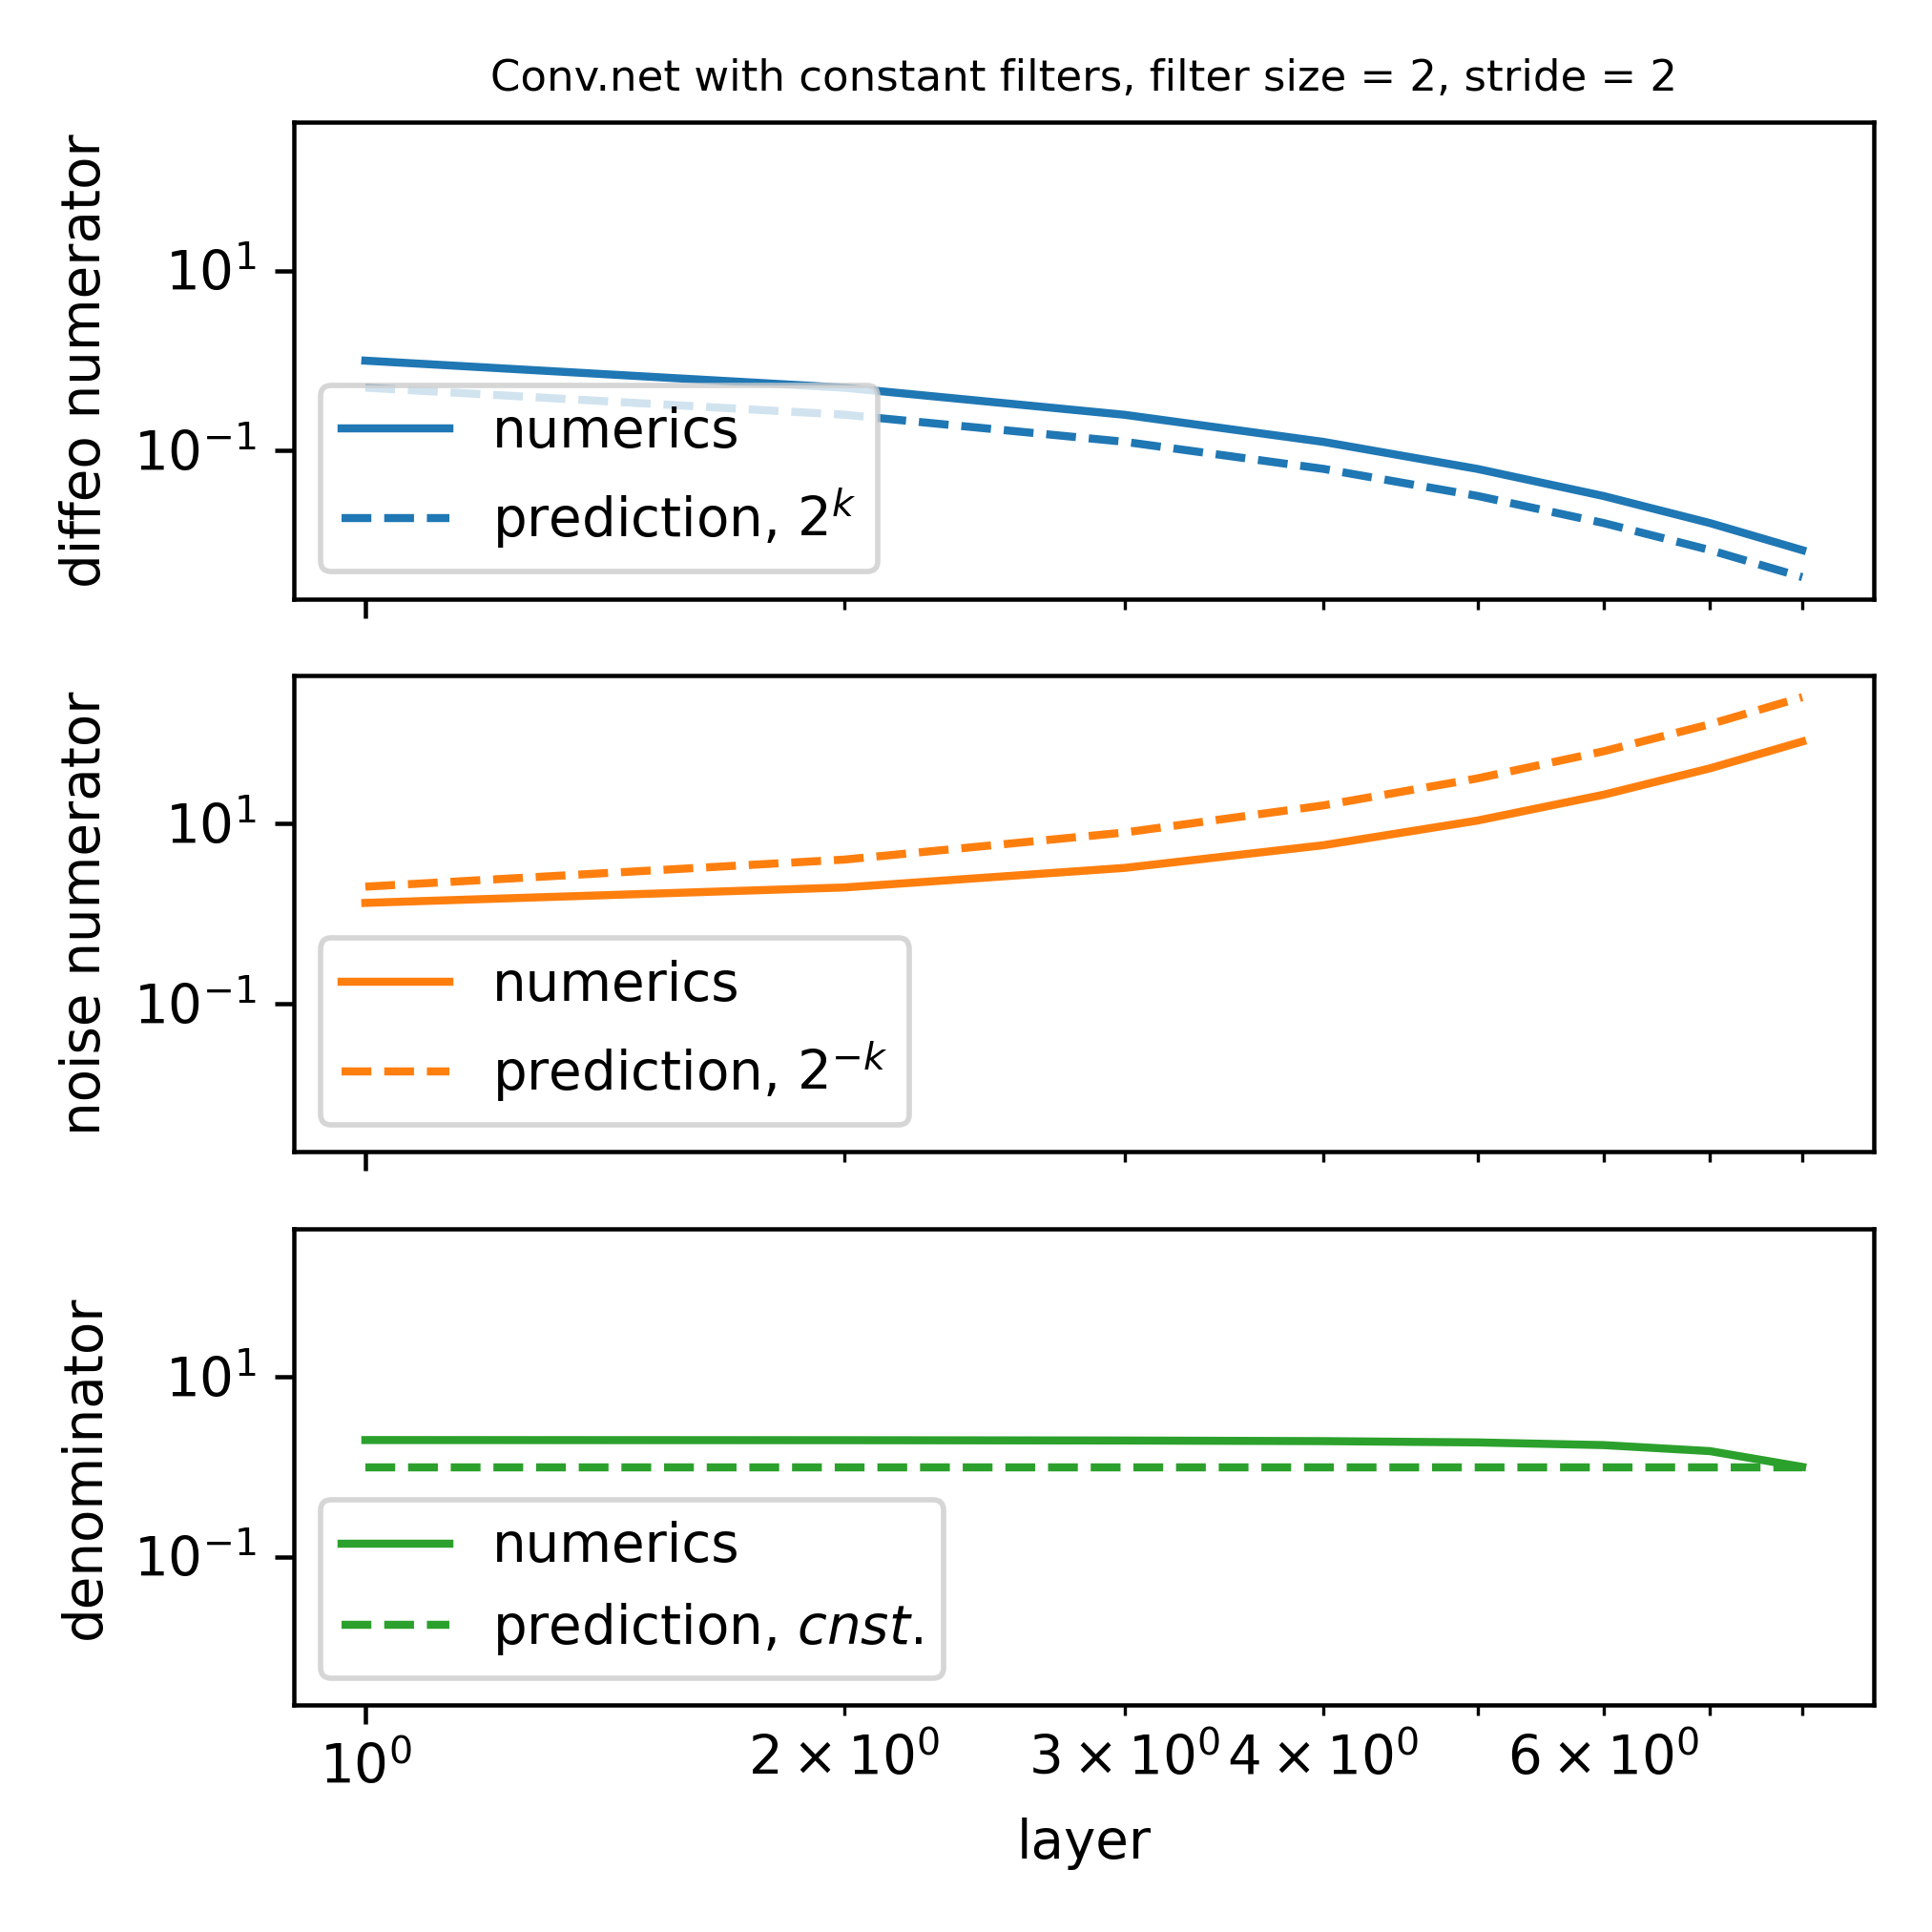

In [12]:
%matplotlib notebook

_, ax = plt.subplots(3, 1, figsize=(5, 5), dpi=180, sharex=True, sharey=True)

ls = torch.arange(1, L + 1).float()

plt.sca(ax[0])
plt.title(f'Conv.net with constant filters, filter size = {kernel_size}, stride = {stride}', fontsize=8) # \n (ReLU at input)
plt.plot(ls, D, 'C0', label='numerics')
if stride == 1:
    plt.plot(ls, ls ** -1.5, '--C0', label='prediction')
elif stride == 2 and kernel_size == 2:
    plt.plot(ls, 2 ** (-ls), '--C0', label='prediction, $2^k$')
elif kernel_size >= 3:
    plt.plot(ls, kernel_size ** (-ls), '--C0', label='prediction, $f_s^{-k}$')
plt.legend(loc='lower left')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('diffeo numerator')

plt.sca(ax[1])
plt.plot(ls, G, 'C1', label='numerics')
if stride == 1:
    plt.plot(ls, .4 * torch.ones(L), '--C1', label='prediction')
elif stride == 2 and kernel_size == 2:
    plt.plot(ls, 2 ** (ls), '--C1', label='prediction, $2^{-k}$')
elif kernel_size >= 3:
    plt.plot(ls, stride ** (ls) / 4, '--C1', label='prediction, $s^{k}$')
plt.legend(loc='lower left')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('noise numerator')

plt.sca(ax[2])
plt.plot(ls, deno, 'C2', label='numerics')
if stride == 1:
    plt.plot(ls, ls ** -.5, '--C2', label='prediction')
elif stride == 2 and kernel_size == 2:
    plt.plot(ls, torch.ones(L), '--C2', label='prediction, $cnst.$')
elif kernel_size >= 3:
    plt.plot(ls, torch.ones(L), '--C2', label='prediction, $cnst.$')
#     plt.ylim(1e-5, 5)
plt.legend(loc='lower left')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('denominator')
plt.xlabel('layer')

plt.tight_layout()

Stabilities: $D_f$, $G_f$, $R_f$

<IPython.core.display.Javascript object>


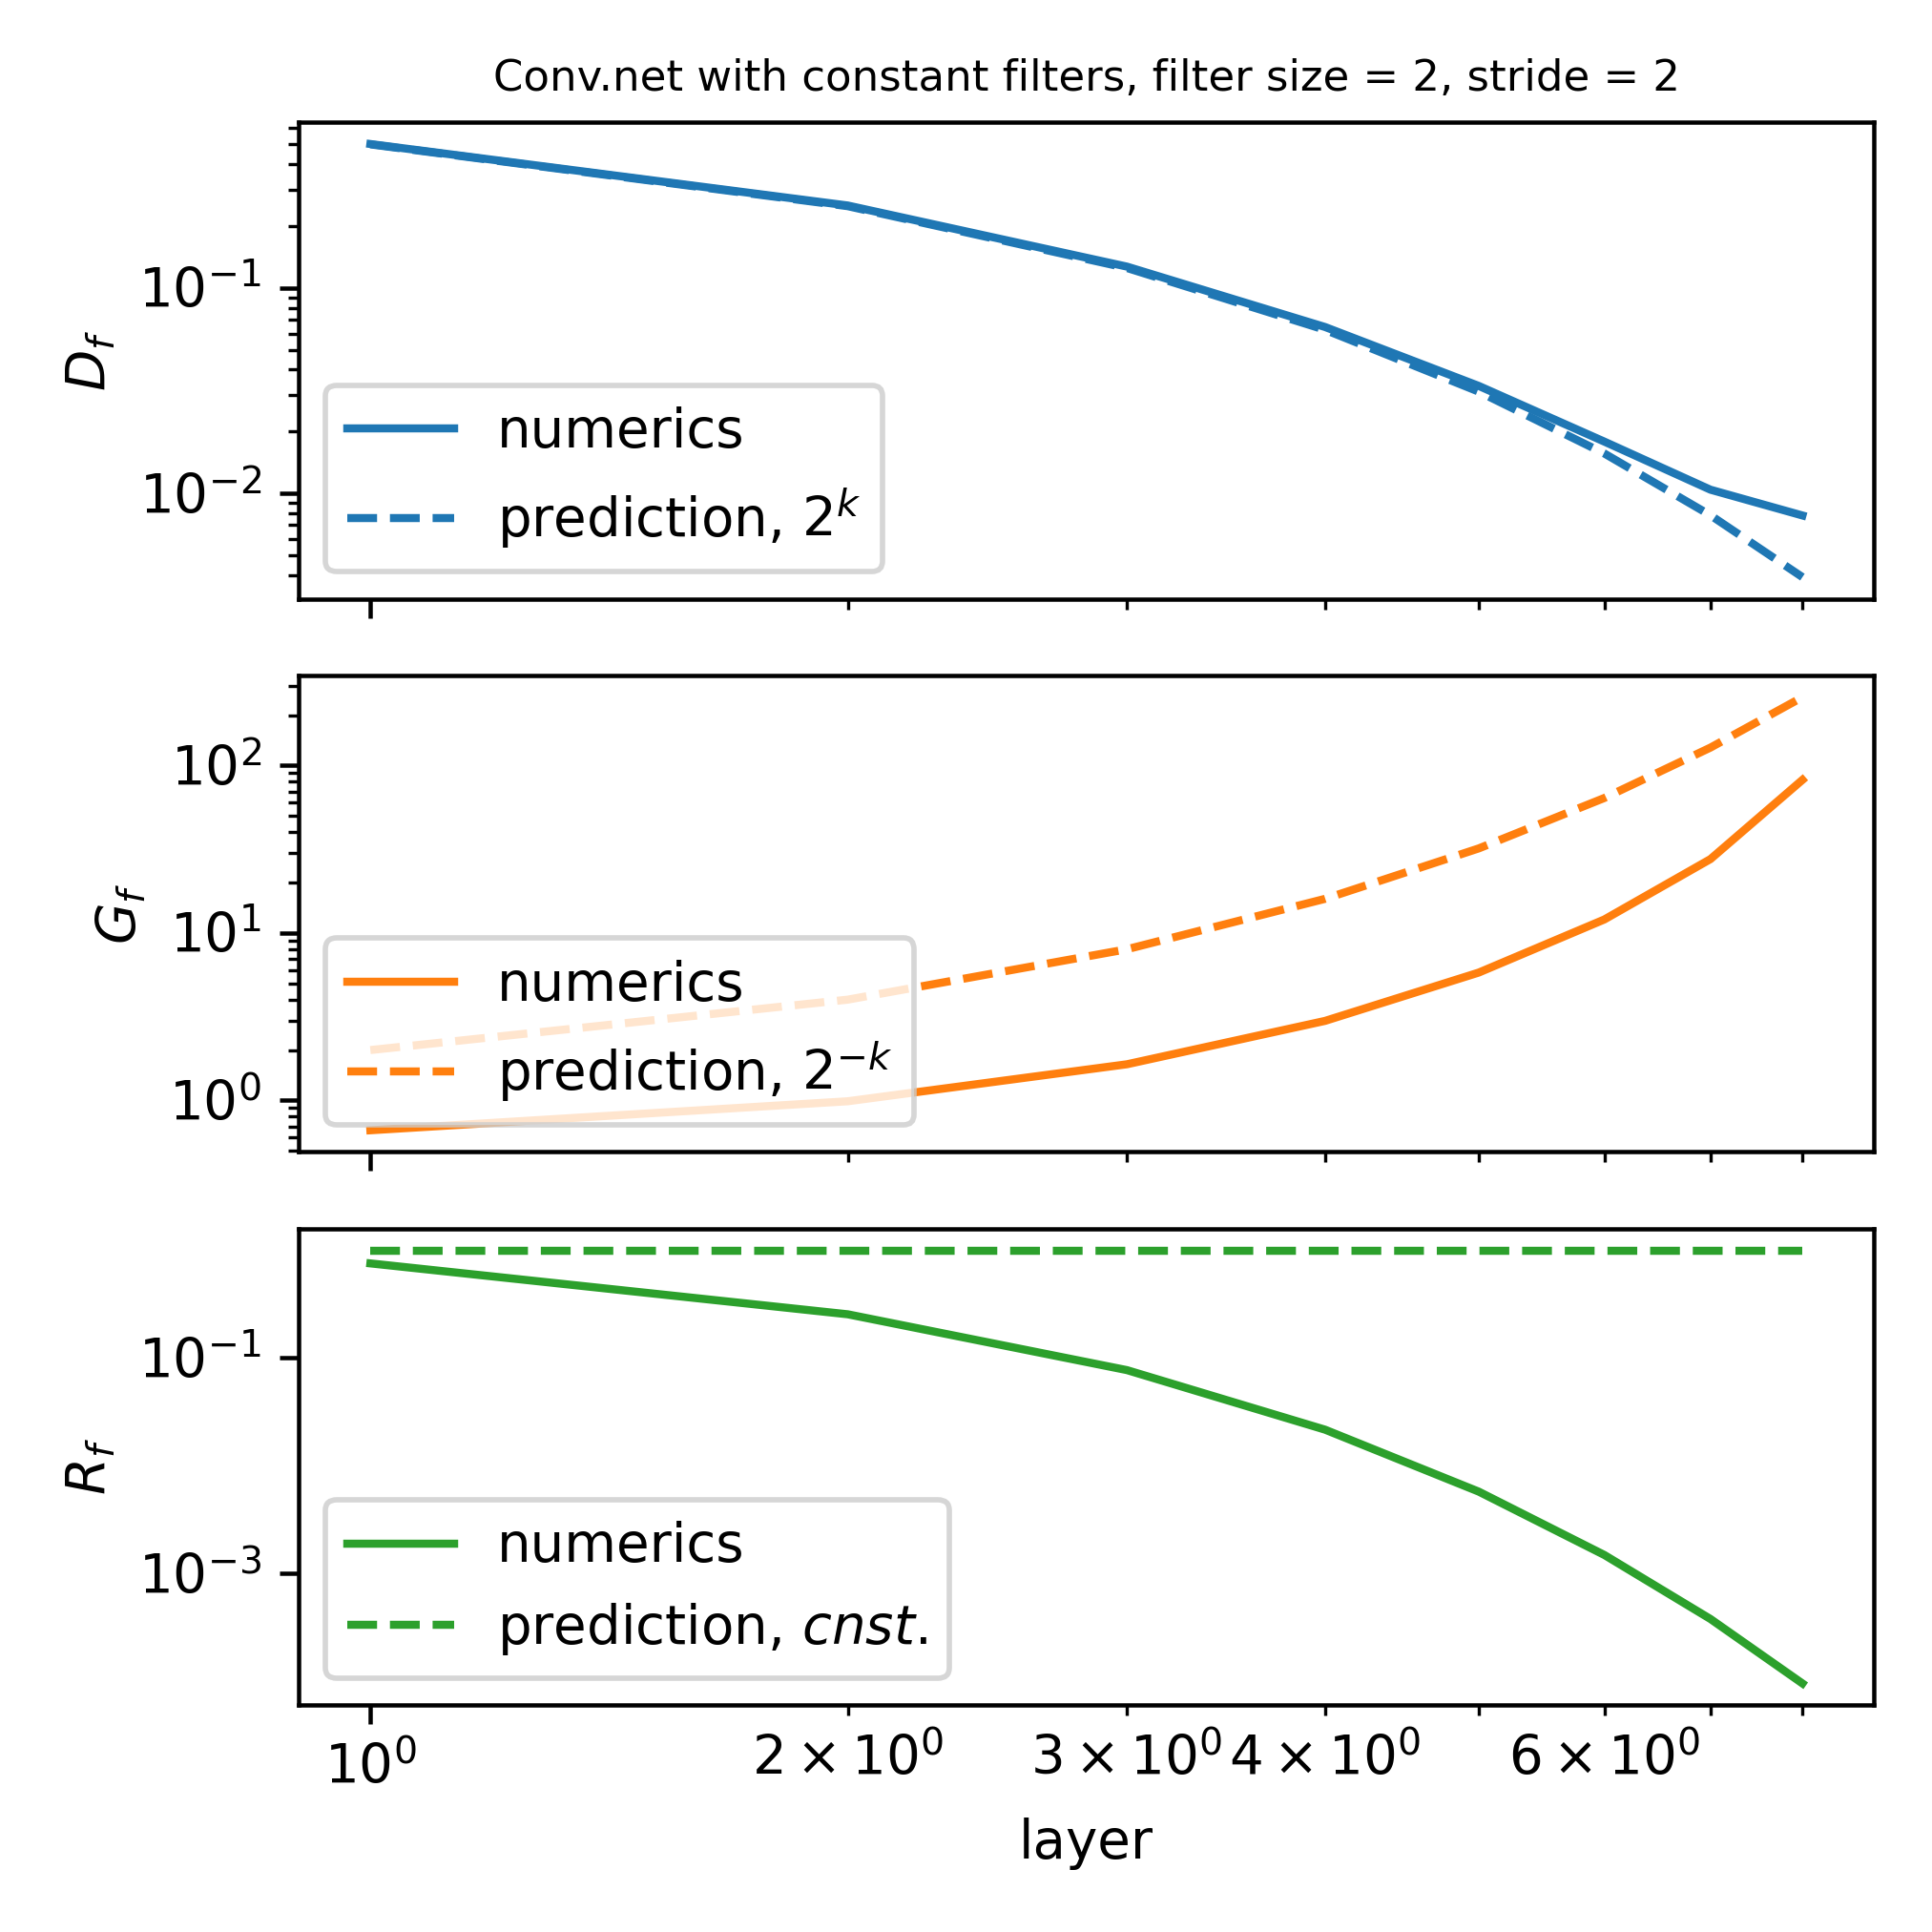

In [13]:
%matplotlib notebook

_, ax = plt.subplots(3, 1, figsize=(5, 5), dpi=180, sharex=True, sharey=False)

ls = torch.arange(1, L + 1).float()

plt.sca(ax[0])
plt.title(f'Conv.net with constant filters, filter size = {kernel_size}, stride = {stride}', fontsize=8) # \n (ReLU at input)
plt.plot(ls, D / deno, 'C0', label='numerics')
if stride == 1:
    plt.plot(ls, ls ** -1, '--C0', label='prediction')
elif stride == 2 and kernel_size == 2 or kernel_size >= 3:
    plt.plot(ls, 2 ** (-ls), '--C0', label='prediction, $2^k$')
plt.legend(loc='lower left')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$D_f$')

plt.sca(ax[1])
plt.plot(ls, G / deno, 'C1', label='numerics')
if stride == 1:
    plt.plot(ls, ls ** .5, '--C1', label='prediction')
elif stride == 2 and kernel_size == 2 or kernel_size >= 3:
    plt.plot(ls, 2 ** (ls), '--C1', label='prediction, $2^{-k}$')
plt.legend(loc='lower left')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$G_f$')

plt.sca(ax[2])
plt.plot(ls, D / G, 'C2', label='numerics')
if stride == 1:
    plt.plot(ls, ls ** -1.5, '--C2', label='prediction')
elif stride == 2 and kernel_size == 2:
    plt.plot(ls, torch.ones(L), '--C2', label='prediction, $cnst.$')
elif kernel_size == 4:
    plt.plot(ls, 8 ** (-ls), '--C0', label='prediction, $2^k$')
plt.legend(loc='lower left')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$R_f$')
plt.xlabel('layer')

plt.tight_layout()

role of bias for Gf vs noise

In [14]:
kernel_size = 3
stride = 2
seeds = 20
L = 4
N = receptive_field(kernel_size, stride, L) + 1

biases = torch.zeros(9)
biases[1:] = 10. ** torch.linspace(-4, -1, 8)
etas = 10. ** torch.linspace(-4, 4, 30)

In [15]:
x = torch.eye(N, device=device)
xd = x.roll(1, 1)

df = []

for bias in tqdm(biases):
    f = ConstantFiltersCNN(kernel_size=kernel_size, stride=stride, depth=L, bias=bias)
    f = f.to(device)
    nodes, _ = get_graph_node_names(f)
    nodes = [n for n in nodes if 'add_3' in n]
    l = create_feature_extractor(f, return_nodes=nodes)
    with torch.no_grad():
        o = l(x)
        od = l(xd)

    for eta in etas:

        for seed in range(seeds):
            xn = noisy_batch1d(x, xd, sigma=eta)
#             xn = xn.relu()
            with torch.no_grad():
                on = l(xn)

            for i, k in enumerate(o):
                D, deno = stability(o[k], od[k])
                G, _ = stability(o[k], on[k])

                df.append({
                    'seed': seed,
                    'layer': k,
                    'li': i,
                    'D': D,
                    'G': G,
                    'deno': deno,
                    'bias': bias.item(),
                    'eta': eta.item()
                })
df = pd.DataFrame.from_records(df)

  0%|          | 0/9 [00:00<?, ?it/s]

In [16]:
df['G'] = df['G'] / df['deno']
# df1 = df[df.apply(lambda a: 'relu' in a.layer, axis=1)]
groups = ['bias', 'eta']
G = df.groupby(groups)['G'].apply(np.mean)

<IPython.core.display.Javascript object>


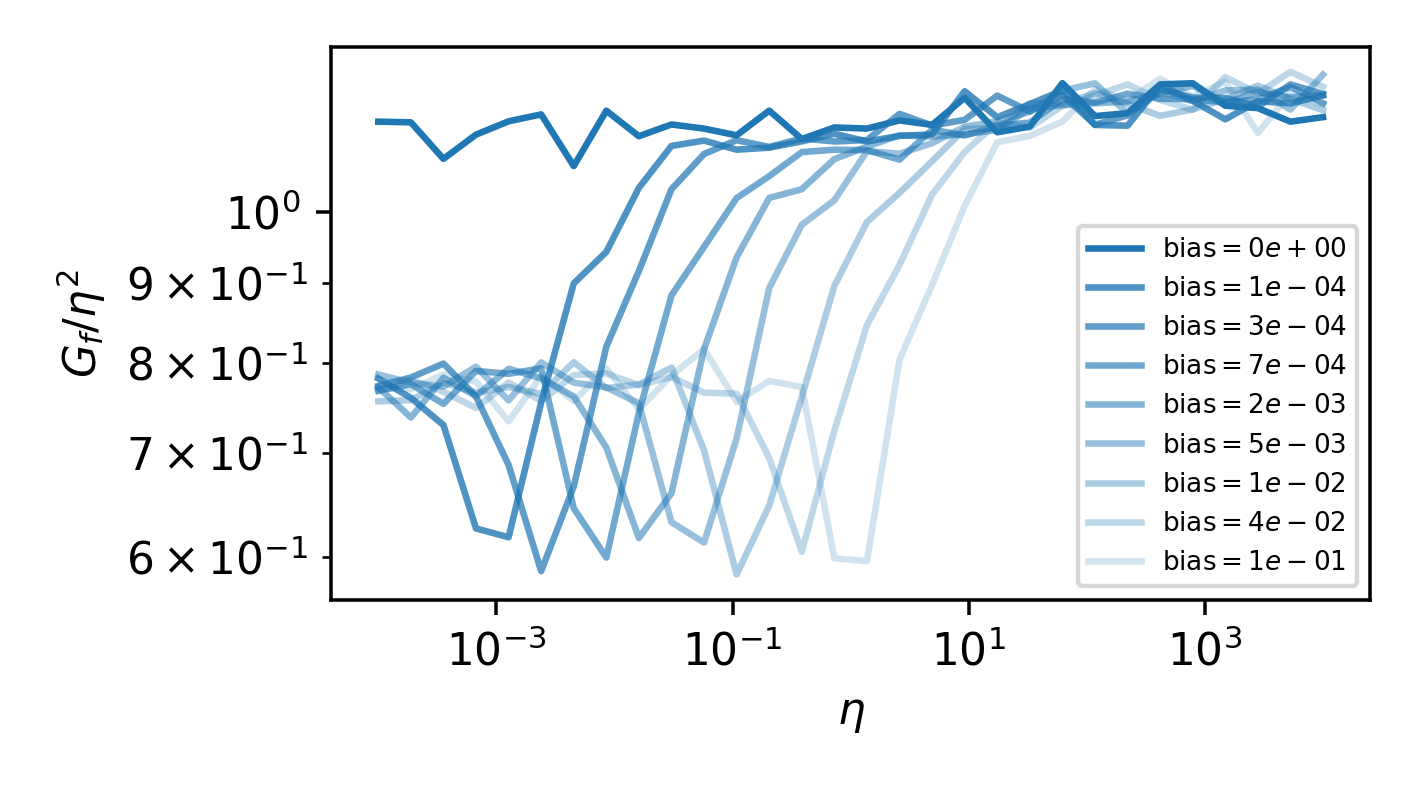

In [17]:
%matplotlib notebook
plt.figure(figsize=(4.5, 2.5), dpi=140)
for bias in biases:
    plt.plot(etas, G[bias.item()].values / etas ** 2, label=f'bias$ = {bias:.00e}$', c='C0', alpha=(-(bias).add(1e-5).log10()).item() / 5)
plt.legend(fontsize=6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\eta$')
plt.ylabel('$G_f / \eta^2$')
plt.tight_layout()

# Compute receptive field

Parameters

In [23]:
device = 'cpu'
filter_size = 3
stride = 2
depth = 3
input_size = receptive_field(filter_size, stride, depth) + 1

In [24]:
f = ConstantFiltersCNN(filter_size, stride, depth, one_filters=1)
x = torch.eye(input_size, device=device)

In [25]:
layers, _ = get_graph_node_names(f)
layers = [l for l in layers if 'relu' in l]
features = create_feature_extractor(f, return_nodes=layers)
out = features(x)
for k in layers:
    out[k] = out[k].t()

In [26]:
for k in layers:
    i = out[k].shape[0] // 2
    a = out[k][i]
    print(a.max().int().item(), end='  ')

1  2  3  

In [27]:
for k in layers:
    i = out[k].shape[0] // 2
    a = out[k][i]
    for ai in a:
        print(int(ai.item()), end=' ')
    print(f' | RF: {sum(a > 0)}')
    
    for ai in a.diff():
        print(int(ai.item()), end=' ')
    print(f' |{sum(a.diff().pow(2).int())}, df: {sum(a.diff().pow(2).int()) / sum(a > 0):.02f}')

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0  | RF: 3
0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 -1 0 0 0 0 0 0 0 0 0 0 0 0 0  |2, df: 0.67
0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0  | RF: 7
0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 -1 1 -1 0 -1 0 0 0 0 0 0 0 0 0 0 0  |6, df: 0.86
0 0 0 0 0 0 0 0 0 1 1 2 1 3 2 3 1 3 2 3 1 2 1 1 0 0 0 0 0 0 0 0  | RF: 15
0 0 0 0 0 0 0 0 1 0 1 -1 2 -1 1 -2 2 -1 1 -2 1 -1 0 -1 0 0 0 0 0 0 0  |26, df: 1.73


Measure Df

In [28]:
Df = []
RF = []
diff = []
for ki, k in enumerate(layers):
    i = out[k].shape[0] // 2
    a = out[k][i]
    Df.append(sum(a.diff().pow(2)).div(sum(a > 0)).mul((stride / filter_size) ** (2 * ki)).item())
    RF.append(sum(a > 0))
    diff.append(sum(a.diff().pow(2)))
Df, 2.**-torch.arange(depth), RF

([0.6666666865348816, 0.380952388048172, 0.3423868417739868],
 tensor([1.0000, 0.5000, 0.2500]),
 [tensor(3), tensor(7), tensor(15)])

Plot Df

<IPython.core.display.Javascript object>


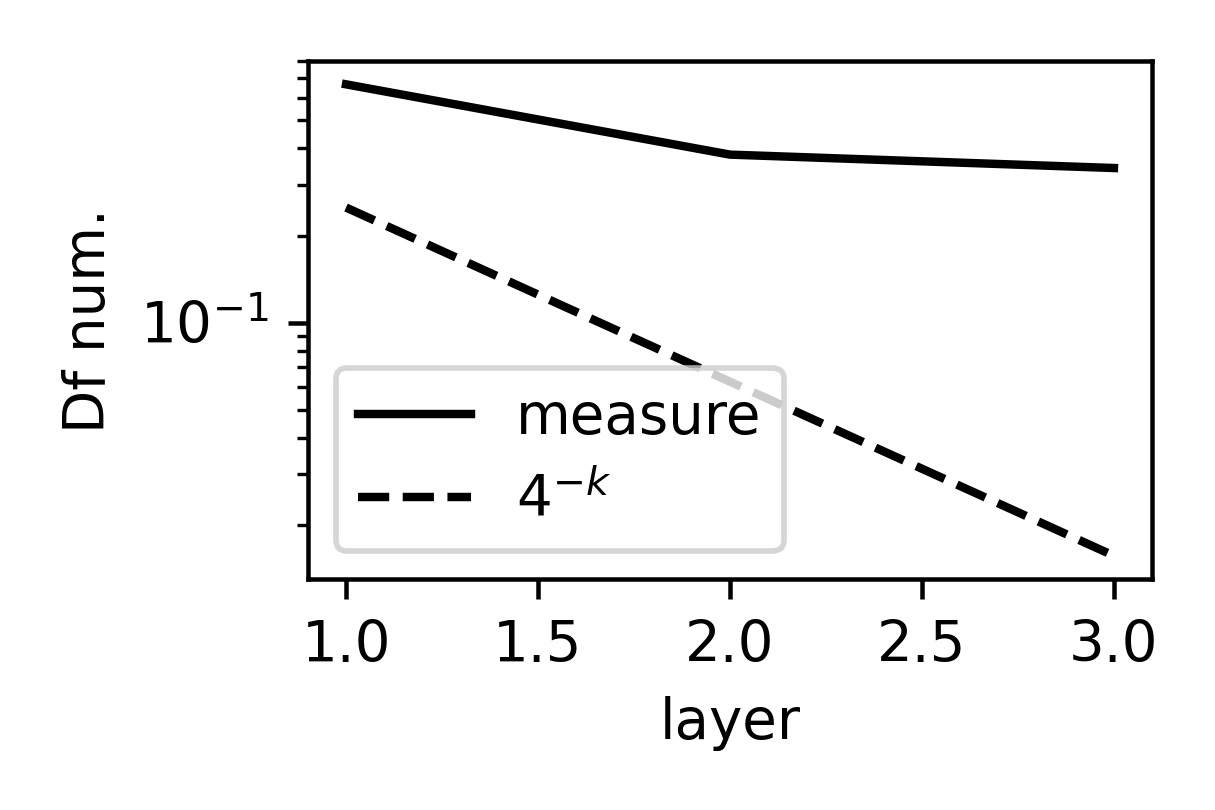

In [29]:
%matplotlib notebook
plt.figure(figsize=(3, 2), dpi=180)
x = torch.arange(1, len(Df) + 1)
plt.plot(x, Df, 'k', label='measure')
plt.plot(x, 4. ** -x, '--k', label='$4^{-k}$')
plt.legend()
plt.yscale('log')
plt.xlabel('layer')
plt.ylabel('Df num.')
plt.tight_layout()

<IPython.core.display.Javascript object>


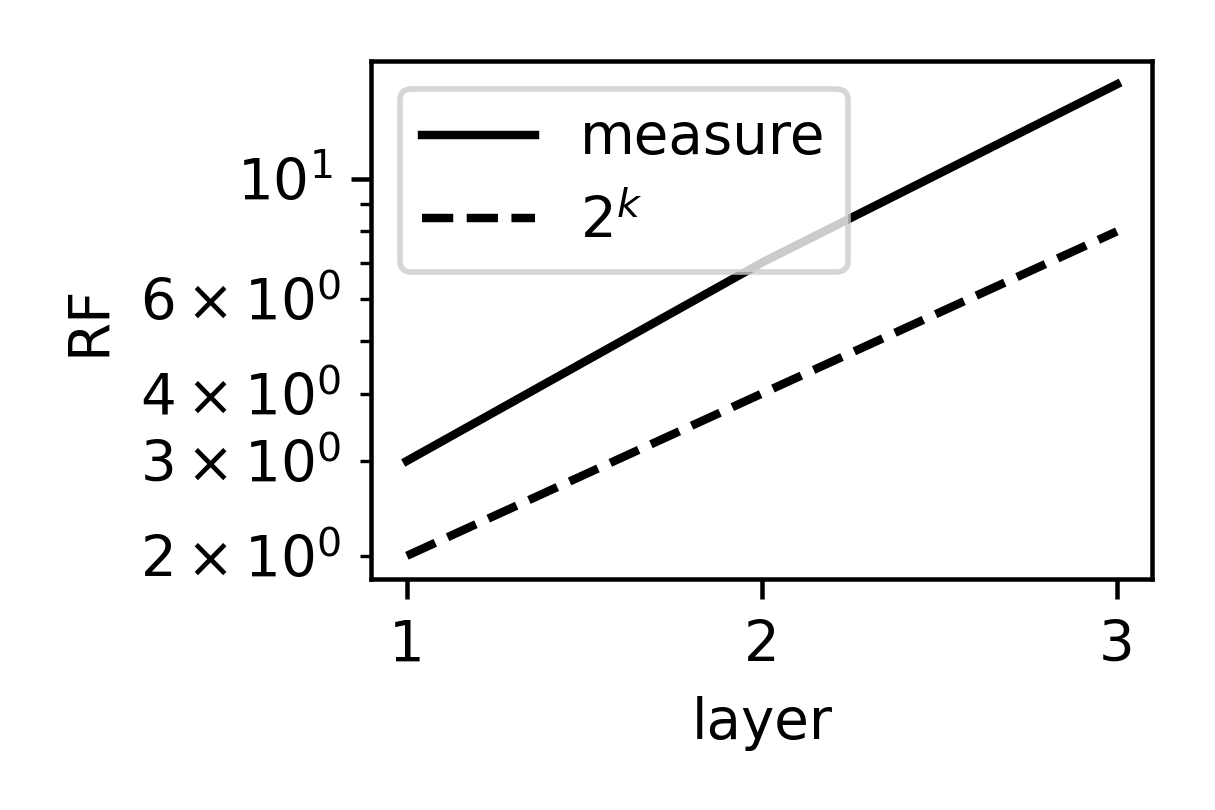

In [30]:
%matplotlib notebook
plt.figure(figsize=(3, 2), dpi=180)
x = torch.arange(1, len(RF) + 1)
plt.plot(x, RF, 'k', label='measure')
plt.plot(x, 2. ** x, '--k', label='$2^{k}$')
plt.legend()
plt.yscale('log')
plt.xlabel('layer')
plt.ylabel('RF')
plt.tight_layout()

<IPython.core.display.Javascript object>


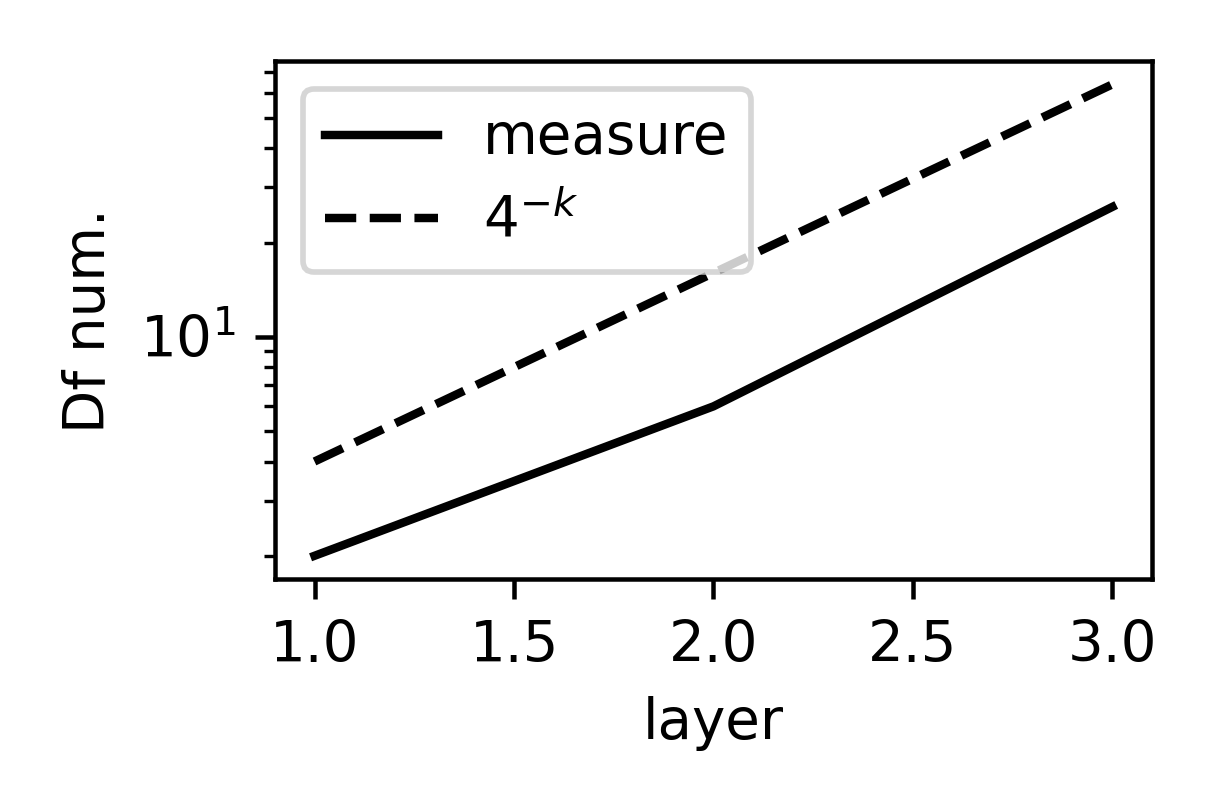

In [31]:
%matplotlib notebook
plt.figure(figsize=(3, 2), dpi=180)
x = torch.arange(1, len(diff) + 1)
plt.plot(x, diff, 'k', label='measure')
base = 4
plt.plot(x, base ** x, '--k', label=f'${base}^{{-k}}$')
plt.legend()
plt.yscale('log')
plt.xlabel('layer')
plt.ylabel('Df num.')
plt.tight_layout()

Check intermediate formula

$n_i^{l+1} = \sum_{j=0}^{f-1} n_{i - j s^l}^l$, with $n_i^l = 0 \text{ if } i < 0, i > RF^l$

In [32]:
RF = torch.zeros(len(layers))
for ki, k in enumerate(layers):
    i = out[k].shape[0] // 2
    a = out[k][i]
    RF[ki] = sum(a > 0)

In [33]:
# def n_recursion(n, f, s, l):
#     N = len(n)
#     nn = torch.zeros(N)
#     for i in range(1, N + 1):
# #         for j in range(- (f - 1) // 2, (f - 1) // 2 + 1):
#         for j in range(f - 1):
            
#             q = j * s ** l
# #             if q >= RF[l] or q < 0: continue

#             try:
#                 nn[i] += n[i + q]
#             except:
#                 pass
# #                 print(i, j * s ^ l)
#     return nn

def n_recursion(n, f, s, l):
    N = len(n)
    nn = torch.zeros(N)
    for i in range(N):
#         for j in range(- (f - 1) // 2, (f - 1) // 2 + 1):
        for j in range(f):
#             print(i - j * s ** l)
            try:
                nn[i] += n[i - j * s ** l]
            except:
                pass
#                 print(i, j * s ^ l)
    return nn

In [34]:
N = input_size
x = torch.zeros(N)
x[:filter_size] = 1

torch.set_printoptions(linewidth=1000, edgeitems=100)

for l in range(depth):
    print(x)
    x = n_recursion(x, filter_size, stride, l+1)
print(x)

tensor([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([1., 1., 2., 1., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([1., 1., 2., 1., 3., 2., 3., 1., 3., 2., 3., 1., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([1., 1., 2., 1., 3., 2., 3., 1., 4., 3., 5., 2., 5., 3., 4., 1., 4., 3., 5., 2., 5., 3., 4., 1., 3., 2., 3., 1., 2., 1., 1., 0.])


In [35]:
for k in out:
    print(out[k][out[k].shape[0] // 2])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 1., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 1., 3., 2., 3., 1., 3., 2., 3., 1., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


Check new formula 31.08

In [36]:
f = 8
s = 2
l = 2

In [37]:
L = 4
for l in range(L):

    RFl = receptive_field(f, s, l)

    n = torch.zeros(RFl + 1)
    for i in range(len(n)):
        for J in product(*[range(f) for _ in range(l)]):
            J = torch.tensor(J)
            S = s ** torch.arange(1, l + 1)
            if i - J.mul(S).sum() == f:
    #             print(J, '-1')
                n[i] -= 1
            if i - J.mul(S).sum() == 0:
    #             print(J, '+1')
                n[i] += 1
    print(n.pow(2).sum().int().item())
n

2
8
56
432


tensor([ 1.,  0.,  1.,  0.,  2.,  0.,  2.,  0.,  3.,  0.,  3.,  0.,  4.,  0.,  4.,  0.,  4.,  0.,  4.,  0.,  4.,  0.,  4.,  0.,  4.,  0.,  4.,  0.,  4.,  0.,  4.,  0.,  3.,  0.,  3.,  0.,  2.,  0.,  2.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  0., -2.,  0., -2.,  0., -3.,  0., -3.,  0., -4.,  0., -4.,  0., -4.,  0., -4.,  0., -4.,  0., -4.,  0., -4.,  0., -4.,  0., -4.,  0., -4.,  0., -3.,  0., -3.,  0., -2.,  0., -2.,  0., -1.,  0., -1.])

Plotting activation evolution

In [47]:
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "DejaVu Sans"
})

In [63]:
os = []
os1 = []

torch.manual_seed(10) # 5

for (kernel_size, stride) in [[5, 1], [2, 2]]:

# kernel_size = 6
# stride = 1
    seeds = 1
    L = 5
    if stride == 1:
        N = receptive_field(kernel_size, stride, L) + 20
    else:
        N = receptive_field(kernel_size, stride, L)

    x = torch.zeros(1, N)
    x1 = torch.zeros(1, N)
    if stride == 1:
        x1[:, N // 4 + 2] = 1
        x[:, N // 4 + 2] = 1
        x[:, -N // 2 + 3] = 1
    else:
        x[:, torch.randint(N, (2,)) - 16 - 2 ** (L)] = 1
#         x[:, 2 ** L] = 1
#         x[:, 2 ** L + 2 ** (L - 1)] = 1

    f = ConstantFiltersCNN(kernel_size=kernel_size, stride=stride, depth=L)
    f = f.to(device)
    nodes, _ = get_graph_node_names(f)
    nodes = [n for n in nodes if 'relu' in n or 'add_5' in n or n == 'x']
    l = create_feature_extractor(f, return_nodes=nodes)
    with torch.no_grad():
        os.append(l(x))
        os1.append(l(x1))

/tmp/ipykernel_19184/270816396.py:20: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1[:, N // 4 + 2] = 1
/tmp/ipykernel_19184/270816396.py:21: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x[:, N // 4 + 2] = 1
/tmp/ipykernel_19184/270816396.py:22: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future versi

<IPython.core.display.Javascript object>


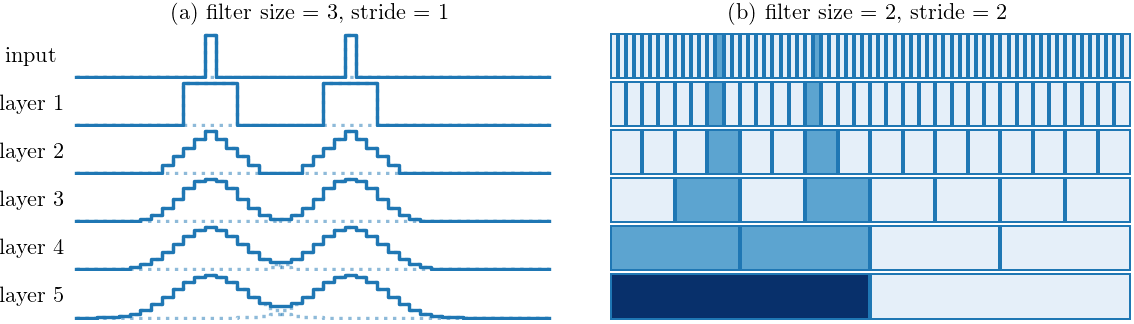

In [64]:
%matplotlib notebook
_, ax = plt.subplots(len(os[0]), 2, figsize=(7, 2), dpi=180, sharex=False, sharey=False)
for oi, o in enumerate(os):
    for i, k in enumerate(o):
        plt.sca(ax[i, oi])
        
        if i == 0:
            fs, s, a = (3, 1, 'a') if oi == 0 else (2, 2, 'b')
            plt.title(f'({a}) filter size = {fs}, stride = {s}', fontsize=10)

#         if i % 3 != 0: continue
        ok = o[k][0]
        if oi == 0:
            ok1 = os1[oi][k][0]
            x = torch.linspace(0, 1, len(ok))
            x = torch.arange(len(ok))
            plt.step(x, ok1, ':C0', alpha=0.5) # , alpha=(i + 4) / (len(o) + 4))
            plt.step(x, ok - ok1, ':C0', alpha=0.5) # , alpha=(i + 4) / (len(o) + 4))
            plt.step(x, ok, 'C0', label=f'layer {i}' if i else 'input') # alpha=(i + 4) / (len(o) + 4))
#             plt.legend(fontsize=6)
            plt.text(-.04, 0.5, f'layer {i}' if i else 'input', horizontalalignment='center', verticalalignment='center',
                     transform=ax[i, oi].transAxes)


        else:
            plt.pcolormesh(ok[None], cmap='Blues', vmin=-.2, vmax=2, edgecolors='C0', lw=1)
            ax[i, oi].set_aspect('auto')
#             ax[i, oi].grid(which='minor', color='C0', linestyle='-', linewidth=2)

        plt.xticks([], [])
        plt.yticks([], [])
        plt.axis('off')

plt.tight_layout(pad = 0.15)
plt.subplots_adjust(wspace=.07, hspace=.04)
plt.savefig('./figures/activations_constant_filters.pdf', format='pdf')

In [66]:
k

'relu_4'

<IPython.core.display.Javascript object>


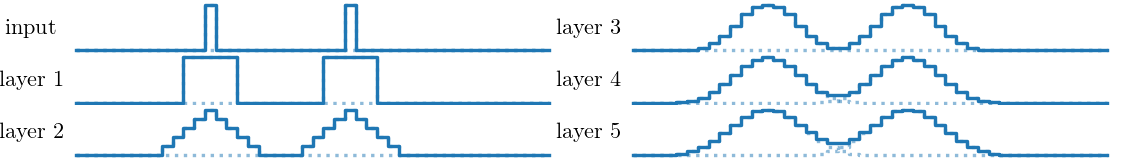

In [67]:
%matplotlib notebook
_, ax = plt.subplots(len(os[0]) // 2, 2, figsize=(7, 1), dpi=180, sharex=False, sharey=False)
for oi, o in enumerate([os[0]]):
    for i, k in enumerate(o):
        plt.sca(ax[i % 3, i // 3])
        
        if i == 0:
            fs, s, a = (3, 1, 'a') if oi == 0 else (2, 2, 'b')
#             plt.title(f'({a}) filter size = {fs}, stride = {s}', fontsize=10)

#         if i % 3 != 0: continue
        ok = o[k][0]
        if oi == 0:
            ok1 = os1[oi][k][0]
            x = torch.linspace(0, 1, len(ok))
            x = torch.arange(len(ok))
            plt.step(x, ok1, ':C0', alpha=0.5) # , alpha=(i + 4) / (len(o) + 4))
            plt.step(x, ok - ok1, ':C0', alpha=0.5) # , alpha=(i + 4) / (len(o) + 4))
            plt.step(x, ok, 'C0', label=f'layer {i}' if i else 'input') # alpha=(i + 4) / (len(o) + 4))
#             plt.legend(fontsize=6)
            plt.text(-.04, 0.5, f'layer {i}' if i else 'input', horizontalalignment='center', verticalalignment='center',
                     transform=ax[i % 3, i // 3].transAxes)


        else:
            plt.pcolormesh(ok[None], cmap='Blues', vmin=-.2, vmax=2, edgecolors='C0', lw=1)
            ax[i, oi].set_aspect('auto')
#             ax[i, oi].grid(which='minor', color='C0', linestyle='-', linewidth=2)

        plt.xticks([], [])
        plt.yticks([], [])
        plt.axis('off')

plt.tight_layout(pad = 0.15)
plt.subplots_adjust(wspace=.07, hspace=.04)
plt.savefig('./figures/activations_constant_filters.pdf', format='pdf')